# Plot Automorphic Groups Temporal SIR-GN

* This notebook plots the size of each automorphic group in datasets DPPIN Tarrasov, Facebook, UCIMsg, and AS.
* Plots are generated for all datasets that have any automorphic groups greater than size 1. That is, any datasets not plotted have unique embeddings (unique temporal structures) for every node in the dataset. This includes datasets Hospital and High School (HS).

## Temporal SIR-GN Code

In [1]:
import pandas as pd 
import numpy as np
class loader:
    
    def __init__(self):
        self.countID=0
        self.G={}
        self.co={}
        self.revco={}
    
    def nodeID(self,x):
        if x not in self.co:
            self.co[x]=self.countID
            self.countID=self.countID+1
            self.revco[self.co[x]]=x
        return self.co[x]
    
    def read(self,file):
        x=file.values
        for a in range(x.shape[0]):
            i=self.nodeID(x[a,0])
            j=self.nodeID(x[a,1])
            self.addEdge((i,j,float(x[a,2])))
        self.fixG()
        
    def storeEmb(self,file,data):
        file1 = open(file, 'w') 
        for a in range(data.shape[0]):
            s=''+str(int(self.revco[a]))
            for b in range(data.shape[1]):
                s+=' '+str(data[a,b])
            file1.write(s+"\n")
        file1.close()
            
    
    def fixG(self):
        for g in range(len(self.G)):
            orderSet=[t for t in self.G[g]]
            orderSet.sort(reverse=True)
            self.G[g]=[(t,np.array([x for x in self.G[g][t]])) for t in orderSet]

    def addEdge(self,s):
        (l1,l2,t)=s
        if l1 not in self.G:
            self.G[l1]={}
        if l2 not in self.G:
            self.G[l2]={}
        if t not in self.G[l1]:
            self.G[l1][t]=set()
        if t not in self.G[l2]:
            self.G[l2][t]=set()   
        self.G[l1][t].add(l2)
        self.G[l2][t].add(l1)

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score
from sklearn.decomposition import PCA,IncrementalPCA,TruncatedSVD

def temporalAggregation1(embd,G,v,alpha):
    k=embd.shape[1]
    h=np.zeros((k,k))
    h1=np.zeros((1,k))
    w=[]
    for i in range(len(G[v])):
        (ti,li)=G[v][i]
        wi=np.zeros((k,))
        for f in li:
            wi+=embd[f,:]
        h1+=wi #sum of all the neighbors reps at this timestamp?
        w.append(wi.reshape((k,1)))
    z=np.zeros((1,k))
    for i in range(1,len(G[v])):
        (tni,li)=G[v][i]
        (tnim1,lim1)=G[v][i-1]
        z=np.exp((tni-tnim1)/alpha)*(w[i-1].transpose()+z)
        a=w[i]*z
        h+=a
    g=h.flatten()
    return np.hstack([g.reshape((1,g.shape[0])),h1])


def temporalAggregation(embd,G,alpha):
    m=[]
    nv=len(G)
    for v in range(nv):
        m.append(temporalAggregation1(embd,G,v,alpha))
    return np.vstack(m)

def getnumber(emb):
    ss=set()
    for x in range(emb.shape[0]):
        sd=''
        for y in range(emb.shape[1]):
            sd+=','+str(emb[x,y])
        ss.add(sd)
    return len(ss)

def temporalSirGN(G,n,alpha,iter=10):
    nv=len(G) 
    embd=np.array([[1/n for i in range(n)] for x in range(nv)])
    emb=temporalAggregation(embd,G,alpha)
    for i in range(iter):
        print(i)
        scaler = MinMaxScaler()
        emb1=scaler.fit_transform(emb)
        kmeans = KMeans(n_clusters=n, random_state=1).fit(emb1)
        val=kmeans.transform(emb1)
        M=val.max(axis=1)
        m=val.min(axis=1)
        subx=(M.reshape(nv,1)-val)/(M-m).reshape(nv,1)
        su=subx.sum(axis=1)
        subx=subx/su.reshape(nv,1)
        emb=temporalAggregation(subx,G,alpha)
    return emb

def temporalSirGNStop(G,n,alpha,iter=100):
    nv=len(G) 
    embd=np.array([[1/n for i in range(n)] for x in range(nv)])
    emb=temporalAggregation(embd,G,alpha)
    count=getnumber(emb)
    print('count',count)
    for i in range(iter):
        print(i)
        scaler = MinMaxScaler()
        emb1=scaler.fit_transform(emb)
        kmeans = KMeans(n_clusters=n, random_state=1).fit(emb1)
        val=kmeans.transform(emb1)
        M=val.max(axis=1)
        m=val.min(axis=1)
        subx=(M.reshape(nv,1)-val)/(M-m).reshape(nv,1)
        #print(subx.shape)
        su=subx.sum(axis=1)
        #print(su.shape)
        subx=subx/su.reshape(nv,1)
        emb2=temporalAggregation(subx,G,alpha)
        count1=getnumber(emb2)
        print('count',count1)
        if count>=count1:
            break
        else:
            emb=emb2
            count=count1
    return emb


In [3]:
import pandas as pd 
import numpy as np
class directed_loader:
    
    def __init__(self):
        self.countID=0
        self.G={}
        self.co={}
        self.revco={}
    
    def nodeID(self,x):
        if x not in self.co:
            self.co[x]=self.countID
            self.countID=self.countID+1
            self.revco[self.co[x]]=x
        return self.co[x]
    
    def read(self,file):
        #x=pd.read_csv(file,sep=' ',header=None).values
        x=file.values
        for a in range(x.shape[0]):
            i=self.nodeID(x[a,0])
            j=self.nodeID(x[a,1])
            self.addEdge((i,j,float(x[a,2])))
        self.fixG()
        
    def storeEmb(self,file,data):
        file1 = open(file, 'w') 
        for a in range(data.shape[0]):
            s=''+str(int(self.revco[a]))
            for b in range(data.shape[1]):
                s+=' '+str(data[a,b])
            file1.write(s+"\n")
        file1.close()
            
    
    def fixG(self):
        for g in range(len(self.G)):
            orderSet=[t for t in self.G[g]]
            orderSet.sort(reverse=True)
            self.G[g]=[(t,np.array([x for x in self.G[g][t]['in']]),np.array([y for y in self.G[g][t]['out']])) for t in orderSet]

            
    def addEdge(self,s):
        (l1,l2,t)=s
        if l1 not in self.G:
            self.G[l1]={}
        if l2 not in self.G:
            self.G[l2]={}
        if t not in self.G[l1]:
            self.G[l1][t]={}
            self.G[l1][t]['out']=set()
            self.G[l1][t]['in']=set()
        if t not in self.G[l2]:
            self.G[l2][t]={}
            self.G[l2][t]['out']=set()
            self.G[l2][t]['in']=set()
        self.G[l1][t]['out'].add(l2)
        self.G[l2][t]['in'].add(l1)

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score
from sklearn.decomposition import PCA,IncrementalPCA,TruncatedSVD



def dirtemporalAggregation1(embd,G,v,alpha):
    k=embd.shape[1]
    h=np.zeros((k*2,k*2))
    h1=np.zeros((1,k*2))
    w=[]
    for i in range(len(G[v])):
        #in is first in tuple, out is second
        (ti,lii, lio)=G[v][i]
        wiin=np.zeros((k,))
        wiout=np.zeros((k,))
        for f in lii:
            wiin+=embd[f,:] #sum of all the neighbors at this timestamp
        for g in lio:
            wiout+=embd[g,:] #sum of all the neighbors at this timestamp
        wiboth=np.hstack([wiin, wiout])
        h1+=wiboth #sum of all the neighbors for all timestamps
        w.append(wiboth.reshape((k*2,1)))
    z=np.zeros((1,k*2))
    for i in range(1,len(G[v])):
        (tni,lii, lio)=G[v][i]
        (tnim1,lim1i, lim1o)=G[v][i-1]
        z=np.exp((tni-tnim1)/alpha)*(w[i-1].transpose()+z)
        a=w[i]*z
        h+=a
    g=h.flatten()
    return np.hstack([g.reshape((1,g.shape[0])),h1])

def dirtemporalAggregation(embd,G,alpha):
    m=[]
    nv=len(G)
    for v in range(nv):
        m.append(dirtemporalAggregation1(embd,G,v,alpha))
    return np.vstack(m)

def getnumber(emb):
    ss=set()
    for x in range(emb.shape[0]):
        sd=''
        for y in range(emb.shape[1]):
            sd+=','+str(emb[x,y])
        ss.add(sd)
    return len(ss)

def dirtemporalSirGN(G,n,alpha,iter=10):
    nv=len(G) 
    embd=np.array([[1/n for i in range(n)] for x in range(nv)])
    emb=dirtemporalAggregation(embd,G,alpha)
    for i in range(iter):
        print(i)
        scaler = MinMaxScaler()
        emb1=scaler.fit_transform(emb)
        kmeans = KMeans(n_clusters=n, random_state=1).fit(emb1)
        val=kmeans.transform(emb1)
        M=val.max(axis=1)
        m=val.min(axis=1)
        subx=(M.reshape(nv,1)-val)/(M-m).reshape(nv,1)
        su=subx.sum(axis=1)
        subx=subx/su.reshape(nv,1)
        emb=dirtemporalAggregation(subx,G,alpha)
    return emb

def dirtemporalSirGNStop(G,n,alpha,iter=100):
    nv=len(G) 
    embd=np.array([[1/n for i in range(n)] for x in range(nv)])
    emb=dirtemporalAggregation(embd,G,alpha)
    count=getnumber(emb)
    print('count',count)
    for i in range(iter):
        print(i)
        scaler = MinMaxScaler()
        emb1=scaler.fit_transform(emb)
        kmeans = KMeans(n_clusters=n, random_state=1).fit(emb1)
        val=kmeans.transform(emb1)
        M=val.max(axis=1)
        m=val.min(axis=1)
        subx=(M.reshape(nv,1)-val)/(M-m).reshape(nv,1)
        #print(subx.shape)
        su=subx.sum(axis=1)
        #print(su.shape)
        subx=subx/su.reshape(nv,1)
        emb2=dirtemporalAggregation(subx,G,alpha)
        count1=getnumber(emb2)
        print('count',count1)
        if count>=count1:
            break
        else:
            emb=emb2
            count=count1
    return emb

## DPPIN dataset

In [5]:
dppin=pd.read_csv('dppintarrasov.txt', names=['src', 'trg', 'time', 'exp'])

In [6]:
dppin.head()

,src,trg,time,exp
0,14,600,0,0.9801
1,22,465,0,0.6732
2,22,651,0,0.6732
3,28,211,0,0.9405
4,41,695,0,0.4624


In [7]:
l=loader()
l.read(dppin)
emb=temporalSirGNStop(l.G,10,10)

count 626
0
count 803
1
count 806
2
count 806


In [8]:
emb.shape

(905, 110)

In [9]:
#905 nodes in the dataset
len(l.G)

905

In [10]:
embdf = pd.DataFrame(emb)

In [11]:
counts = np.array(embdf.value_counts())

In [12]:
counts

array([18, 10, 10,  4,  4,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [13]:
len(pd.Series(counts).unique())

6

In [14]:
len(counts)

806

In [15]:
# should total to the number of nodes
sum(counts)

905

In [16]:
# number of nodes with unique temporal structure
list(counts).count(1)

746

In [17]:
# percent of nodes with unique temporal structure
746/905

0.8243093922651934

Text(0, 0.5, 'Count')

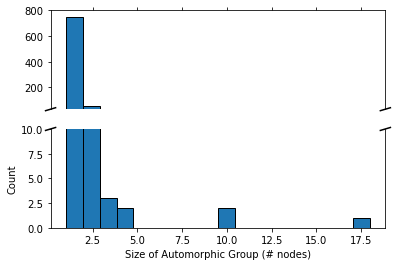

In [18]:
import matplotlib.pyplot as plt
import numpy as np



f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
ax.hist(counts, bins=18, edgecolor='black')
ax2.hist(counts, bins=18, edgecolor='black')

# zoom-in / limit the view to different portions of the data
ax.set_ylim(30, 800)  
ax2.set_ylim(0, 10)  

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = .015  

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


#ax.set_title('Distribution of Sizes of Automorphic Groups')
plt.xlabel('Size of Automorphic Group (# nodes)')
plt.ylabel('Count')
#plt.savefig('DPPINDist.pdf', bbox_inches='tight')

## Facebook

In [19]:
facebook = pd.read_csv('facebook.txt', sep=' ', names=['time', 'source', 'target'], header=None)

In [20]:
facebook.head()

,time,source,target
0,2006-05-09 04:10:57,12830,14791
1,2006-05-09 04:11:43,11072,21587
2,2006-05-09 04:20:43,12830,14797
3,2006-05-09 04:27:05,1084,6297
4,2006-05-09 04:28:42,9089,2304


In [21]:
from dateutil import parser
from datetime import datetime
facebook['newtime'] = facebook[['time']].apply(lambda x: datetime.timestamp(parser.parse(x[0])), axis=1)

In [22]:
facebook.drop(columns=['time'], inplace=True)

In [23]:
l=loader()
l.read(facebook)
emb=temporalSirGNStop(l.G,10,10)

count 1082
0
count 2526
1
count 3245
2
count 3348
3
count 3347


In [24]:
len(l.G)

4117

In [25]:
embdf = pd.DataFrame(emb)

In [26]:
counts = np.array(embdf.value_counts())

In [27]:
counts

array([328,  74,  52, ...,   1,   1,   1])

In [28]:
len(counts)

3348

In [29]:
list(counts).count(1)

3162

In [30]:
3164/4117

0.7685207675491863

Text(0, 0.5, 'Count')

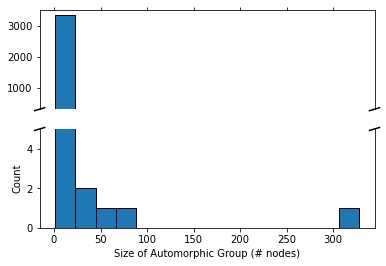

In [31]:


f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
ax.hist(counts, bins=15, edgecolor='black')
ax2.hist(counts, bins=15, edgecolor='black')

# zoom-in / limit the view to different portions of the data
ax.set_ylim(300, 3500)  
ax2.set_ylim(0, 5)  

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = .015  

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


#ax.set_title('Distribution of Sizes of Automorphic Groups')
plt.xlabel('Size of Automorphic Group (# nodes)')
plt.ylabel('Count')
#plt.savefig('FacebookDist.pdf', bbox_inches='tight')

## UCI Messages

In [32]:
uci = pd.read_csv('ucigraph.txt', sep=' ', header=None, names=['src', 'trg', 'weight', 'time'])

In [33]:
uci.head()

,src,trg,weight,time
0,1,2,1,1082008561
1,3,4,1,1082123439
2,5,2,1,1082381991
3,6,7,1,1082407219
4,8,7,1,1082407356


In [34]:
uci.drop(columns=['weight'], inplace=True)

In [35]:
l=loader()
l.read(uci)
emb=temporalSirGNStop(l.G,10,10)

count 1362
0
count 1762
1
count 1762


In [36]:
len(l.G)

1899

In [37]:
embdf = pd.DataFrame(emb)

In [38]:
counts = np.array(embdf.value_counts())

In [39]:
counts

array([13, 11, 11, ...,  1,  1,  1])

In [40]:
len(counts)

1762

In [41]:
list(counts).count(1)

1716

In [42]:
1716/1899

0.9036334913112164

Text(0, 0.5, 'Count')

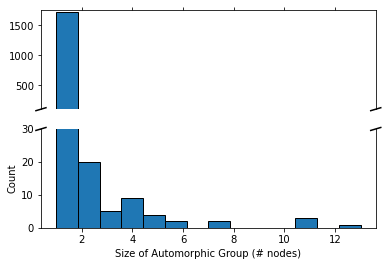

In [43]:



f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
ax.hist(counts, bins=14, edgecolor='black')
ax2.hist(counts, bins=14, edgecolor='black')

# zoom-in / limit the view to different portions of the data
ax.set_ylim(100, 1750)  
ax2.set_ylim(0, 30)  

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = .015  

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


#ax.set_title('Distribution of Sizes of Automorphic Groups')
plt.xlabel('Size of Automorphic Group (# nodes)')
plt.ylabel('Count')
#plt.savefig('UCIDist.pdf', bbox_inches='tight')

## AS dataset

In [44]:
asdata = pd.read_csv('janet_as.csv', sep=',')

In [45]:
asdata.head()

,from_id,to_id,time
0,1,701,19990824
1,1,7018,19990824
2,1,1673,19990824
3,1,2914,19990824
4,1,1239,19990824


In [46]:
l=loader()
l.read(asdata)
emb=temporalSirGNStop(l.G,10,10)

count 4433
0
count 6067
1
count 6067


In [47]:
embdf = pd.DataFrame(emb)

In [48]:
len(l.G)

6828

In [49]:
counts = np.array(embdf.value_counts())

In [50]:
counts

array([53, 25, 23, ...,  1,  1,  1])

In [51]:
len(counts)

6067

In [52]:
list(counts).count(1)

5813

In [53]:
5813/6828

0.8513473930872877

Text(0, 0.5, 'Count')

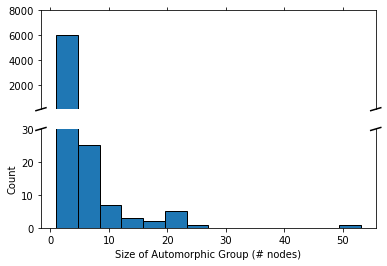

In [54]:


f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
ax.hist(counts, bins=14, edgecolor='black')
ax2.hist(counts, bins=14, edgecolor='black')

# zoom-in / limit the view to different portions of the data
ax.set_ylim(30, 8000)  
ax2.set_ylim(0, 30)  

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = .015  

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


#ax.set_title('Distribution of Sizes of Automorphic Groups')
plt.xlabel('Size of Automorphic Group (# nodes)')
plt.ylabel('Count')
#plt.savefig('ASDist.pdf', bbox_inches='tight')

## Bitcoin

In [55]:
otc = pd.read_csv('otc_network.csv', header=None, names=['src', 'trg', 'edgelab', 'time'])

In [56]:
otc.head()

,src,trg,edgelab,time
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


In [57]:
otc.drop(columns=['edgelab'], inplace=True)

In [58]:
l=directed_loader()
l.read(otc)
emb=dirtemporalSirGNStop(l.G,10,10)

count 4421
0
count 5131
1
count 5137
2
count 5137


In [59]:
len(l.G)

5881

In [60]:
embdf = pd.DataFrame(emb)

In [61]:
embdf.value_counts()

0         1         2         3         4         5    6         7        8         9         10            11            12            13            14            15   16            17            18            19            20        21        22        23        24        25   26        27        28        29        30            31            32            33            34            35   36            37            38            39            40        41        42        43        44        45   46        47        48        49        50            51            52            53            54            55   56            57            58            59            60        61        62        63        64        65   66        67        68        69        70            71            72            73            74            75   76            77            78            79            80        81        82        83        84        85   86        87        88        89        90

In [62]:
counts = np.array(embdf.value_counts())

In [63]:
counts

array([185, 105,  71, ...,   1,   1,   1])

In [64]:
len(counts)

5137

In [65]:
list(counts).count(1)

5005

Text(0, 0.5, 'Count')

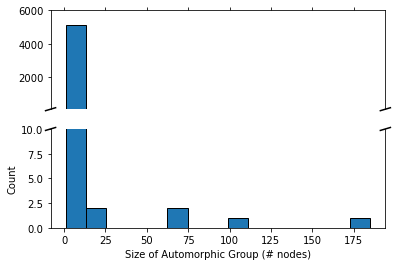

In [66]:


f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
ax.hist(counts, bins=15, edgecolor='black')
ax2.hist(counts, bins=15, edgecolor='black')

# zoom-in / limit the view to different portions of the data
ax.set_ylim(100, 6000)  
ax2.set_ylim(0, 10)  

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = .015  

kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


#ax.set_title('Distribution of Sizes of Automorphic Groups')
plt.xlabel('Size of Automorphic Group (# nodes)')
plt.ylabel('Count')
#plt.savefig('OTCDist.pdf', bbox_inches='tight')

## Hospital

In [67]:
hospital = pd.read_csv('hospital.txt', sep='\t', header=None, names=['time', 'src', 'trg', 'src_lab', 'trg_lab'])

In [68]:
hospital.head()

,time,src,trg,src_lab,trg_lab
0,140,1157,1232,MED,ADM
1,160,1157,1191,MED,MED
2,500,1157,1159,MED,MED
3,520,1157,1159,MED,MED
4,560,1159,1191,MED,MED


In [69]:
hosp = pd.DataFrame(hospital['src'])
hosp['trg'] = hospital['trg']
hosp['time'] = hospital['time']

In [70]:
hosp

,src,trg,time
0,1157,1232,140
1,1157,1191,160
2,1157,1159,500
3,1157,1159,520
4,1159,1191,560
...,...,...,...
32419,1295,1629,347600
32420,1383,1629,347600
32421,1232,1295,347620
32422,1383,1629,347620


In [71]:
l=loader()
l.read(hosp)
emb=temporalSirGNStop(l.G,10,10)

count 75
0
count 75


In [72]:
len(l.G)

75

In [73]:
embdf = pd.DataFrame(emb)

In [74]:
counts = np.array(embdf.value_counts())

In [75]:
counts

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [76]:
list(counts).count(1)

75

In [77]:
len(counts)

75

# High School

In [78]:
high = pd.read_csv('highschool_2012.csv', sep='\t', header=None, names=['time', 'src', 'trg', 'src_lab', 'trg_lab'])

In [79]:
high

,time,src,trg,src_lab,trg_lab
0,1353303380,1170,1644,MP*1,MP*1
1,1353303400,1170,1613,MP*1,MP*1
2,1353303640,1170,1644,MP*1,MP*1
3,1353303760,1181,1651,MP*1,MP*1
4,1353303840,1108,1190,MP*1,MP*1
...,...,...,...,...,...
45042,1354032580,880,887,PC*,PC*
45043,1354032580,854,869,PSI*,PSI*
45044,1354032600,880,887,PC*,PC*
45045,1354032760,620,669,MP*2,MP*2


In [80]:
hschool = pd.DataFrame(high['src'])
hschool['trg'] = high['trg']
hschool['time'] = high['time']

In [81]:
hschool

,src,trg,time
0,1170,1644,1353303380
1,1170,1613,1353303400
2,1170,1644,1353303640
3,1181,1651,1353303760
4,1108,1190,1353303840
...,...,...,...
45042,880,887,1354032580
45043,854,869,1354032580
45044,880,887,1354032600
45045,620,669,1354032760


In [82]:
l=loader()
l.read(hschool)

In [83]:
emb = temporalSirGNStop(l.G,10,10)

count 180
0
count 180


In [84]:
embdf = pd.DataFrame(emb)

In [85]:
counts = np.array(embdf.value_counts())

In [86]:
counts

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [87]:
len(counts)

180

In [88]:
list(counts).count(1)

180